## Particle aggregation

### Imports

In [1]:
# Adding packages
using Pkg
Pkg.add("CellBasedModels")
Pkg.add("GLMakie")

# Enabling packages
using CellBasedModels
using GLMakie

Makie.inline!(true);

   Resolving package versions...

  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Manifest.toml`


   Resolving package versions...


  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Manifest.toml`


### Code

#### Construct the AgentBasedModel (ABM)

In [2]:
model = ABM(2,

    #In the keyword argument agent we declare all the agent arguments and its scope
    agent = Dict(
        :fx => Float64,
        :fy => Float64,
        ),

    #In the keyword argument model we declare all the model arguments and its scope
    model = Dict(
        :rRep => Float64,
        :fRep => Float64,
        :rAtr => Float64,
        :fAtr => Float64,
        :D => Float64
        ),

    # In here we define the ODE part
    agentODE = quote
        # Compute adhesion and repulsion forces
            # Reset the parameters to zero zero
        fx = 0
        fy = 0
            # Go over the neighbors and add the forces, for that we use the macro @loopOverNeighbors
        @loopOverNeighbors i2 begin
            d = CBMMetrics.euclidean(x,x[i2],y,y[i2])
            dirx = (x-x[i2])/d
            diry = (y-y[i2])/d
            if d < rRep # Repulsion forces
                fx += fRep*(rRep-d)*dirx
                fy += fRep*(rRep-d)*diry
            elseif d < rAtr # Attraction forces
                fx += -fAtr*(rAtr-d)*dirx
                fy += -fAtr*(rAtr-d)*diry
            end
        end
            # Add the forces comming from the boundary interaction
        if x < simBox[1,1]+rRep/2
            fx += fRep
        elseif x > simBox[1,2]-rRep/2
            fx -= fRep
        end
        if y < simBox[2,1]+rRep/2
            fy += fRep
        elseif y > simBox[2,2]/2
            fy -= fRep
        end
    
        # Finally, define the deterministic terms of the SDE
        dt(x) = fx
        dt(y) = fy
    end,

    # In here we define the SDE part
    agentSDE = quote
        # SDE term
        dt(x) = D
        dt(y) = D 
    end
);

#### Tests

##### Test repulsion from other agents

In [3]:
simBox = [-5. 5; -2 2]
#Initialize community
com = Community(model,
        N=2,
        dt=.1,
        simBox = simBox
        );

#Setup user paramaters
        #Constants
com.rRep=.8
com.fRep=1
com.rAtr=1.
com.fAtr=1.
        #Agent parameters
com.x=[-.1,.1]
com.y=[0.,0.];
# If we do not define fx and fy, they are initialy set to zeros

2-element Vector{Float64}:
 0.0
 0.0

In [4]:
evolve!(com,steps=50)

┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase C:\Users\s361359\.julia\packages\SciMLBase\8XHkk\src\performance_warnings.jl:32


In [5]:
d = getParameter(com,[:t,:x,:y,:fx,:fy])

Dict{Symbol, Vector} with 5 entries:
  :fy => [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0…
  :y  => [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0…
  :fx => [[-0.6, 0.6], [-0.6, 0.6], [-0.48, 0.48], [-0.36, 0.36], [-0.264, 0.26…
  :t  => [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0  …  4.1, 4.2, 4.3, 4…
  :x  => [[-0.1, 0.1], [-0.16, 0.16], [-0.22, 0.22], [-0.268, 0.268], [-0.304, …

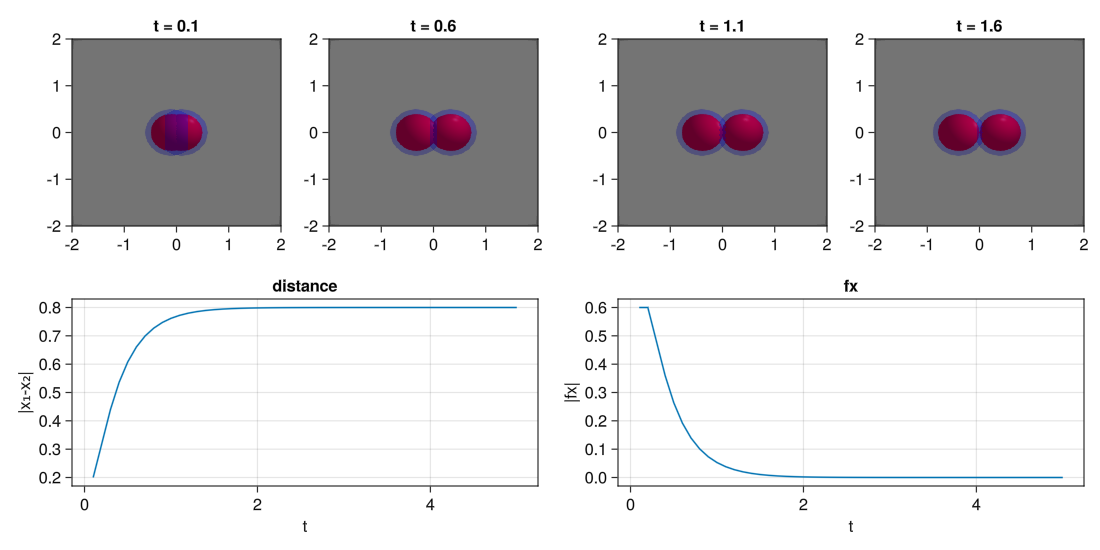

GLMakie.Screen(...)

In [6]:
#Make the plot
fig = Figure(resolution=(1100,550))

#Plot the spheres at different times
for (j,i) in enumerate(1:5:20) #Step times
    #Create axis
    ax = Axis(fig[1,j],title="t = $(round(d[:t][i],digits=2))")
    #Add a simulation box rectangle in the background
    mesh!(ax, [simBox[1,1] simBox[2,1];simBox[1,1] simBox[2,2];simBox[1,2] simBox[2,2];simBox[1,2] simBox[2,1]], [1 2 4; 2 3 4], color=:lightgrey)
    #Add spheres with attraction radius    
    meshscatter!(ax,d[:x][i],d[:y][i],markersize=com[:rAtr][1]/2,color=(:blue,.3),transparency=true)
    #Add spheres with attraction radius
    meshscatter!(ax,d[:x][i],d[:y][i],markersize=com[:rRep][1]/2,color=:red)
    #Define the limits
    xlims!(ax,-2,2)
    ylims!(ax,-2,2)
end

#Plot position over time of one of the particles
ax = Axis(fig[2,1:2],title="distance",xlabel="t",ylabel="|x₁-x₂|")
lines!(d[:t],[abs(j-i) for (i,j) in d[:x]])

#Plot forces over time of one of the particles
ax = Axis(fig[2,3:4],title="fx",xlabel="t",ylabel="|fx|")
lines!(d[:t],[abs(i) for (i,j) in d[:fx]])

#Show the plots
display(fig)
#save("C:/Users/s361359/CellBasedModelsF1/results/examples/particle_aggregation_repulsion_agents_example.png", fig)

##### Test repulsion from the boundaries

In [7]:
simBox = [-2. 2; -2 2]
#Initialize community
com = Community(model,
        N=1,
        dt=.1,
        simBox = simBox,
        );

#Setup user paramaters
com.rRep=.8
com.fRep=1
com.rAtr=1.
com.fAtr=1.
com.x=[0]
com.y=[-2.5];

In [8]:
#Evolve
evolve!(com,steps=15)

In [9]:
#Get parameters
d = getParameter(com,[:t,:x,:y,:fx,:fy])

Dict{Symbol, Vector} with 5 entries:
  :fy => [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0],…
  :y  => [[-2.5], [-2.4], [-2.3], [-2.2], [-2.1], [-2.0], [-1.9], [-1.8], [-1.7…
  :fx => [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0],…
  :t  => [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4,…
  :x  => [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0],…

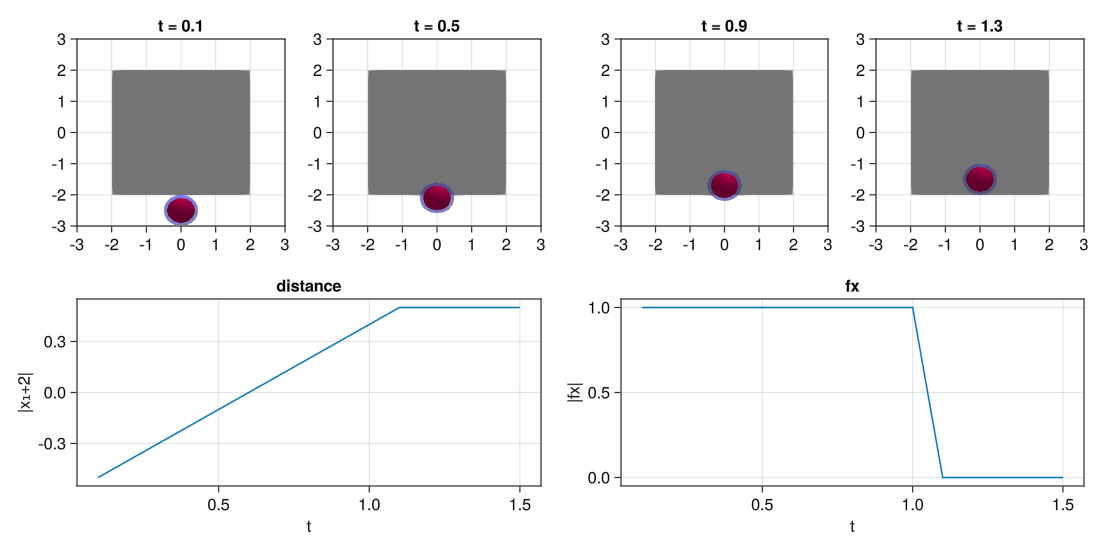

GLMakie.Screen(...)

In [10]:
#Plot
fig = Figure(resolution=(1100,550))

#Plot visually the results
for (j,i) in enumerate(1:4:13)
    ax = Axis(fig[1,j],title="t = $(round(d[:t][i],digits=2))")
    mesh!(ax, [simBox[1,1] simBox[2,1];simBox[1,1] simBox[2,2];simBox[1,2] simBox[2,2];simBox[1,2] simBox[2,1]], [1 2 4; 2 3 4], color=:lightgrey)
    meshscatter!(ax,d[:x][i],d[:y][i],markersize=com[:rAtr][1]/2,color=(:blue,.3),transparency=true)
    meshscatter!(ax,d[:x][i],d[:y][i],markersize=com[:rRep][1]/2,color=:red)
    xlims!(ax,-3,3)
    ylims!(ax,-3,3)
end

#Plot position in i
ax = Axis(fig[2,1:2],title="distance",xlabel="t",ylabel="|x₁+2|")
lines!(d[:t],[i+2 for (i,) in d[:y]])

#Plot forces in i
ax = Axis(fig[2,3:4],title="fx",xlabel="t",ylabel="|fx|")
lines!(d[:t],[abs(i) for (i,) in d[:fy]])

display(fig)
#save("C:/Users/s361359/CellBasedModelsF1/results/examples/particle_aggregation_repulsion_boundaries_example.png", fig)

#### Constructing over a predefined model

In [11]:
model2 = ABM(2,

    #Import the previous model
    baseModelInit = [model],

    #Add an additional model parameter that defines the speed of the diffusion parameter decay
    model = Dict(
        :αT => Float64
    ),

    #Add a ODE to describe the difussion
    modelODE = quote
        dt(D) = -αT*D
    end,

    agentAlg = CBMIntegrators.EM(),
    modelAlg = DifferentialEquations.Euler(),
    neighborsAlg = CBMNeighbors.CellLinked(cellEdge=2),
);

In [12]:
simBox = [-10. 10; -10 10]
N = 100
com = Community(model2,
        N=N,
        dt=0.1,
        simBox = simBox,
        )

com.rRep=.8
com.fRep=1
com.rAtr=1.
com.fAtr=1.
com.αT=.001 
com.x = 20 .*rand(N) .-10
com.y = 20 .*rand(N) .-10
com.D=.15

0.15

In [13]:
evolve!(com,steps=8000,saveEach=1)

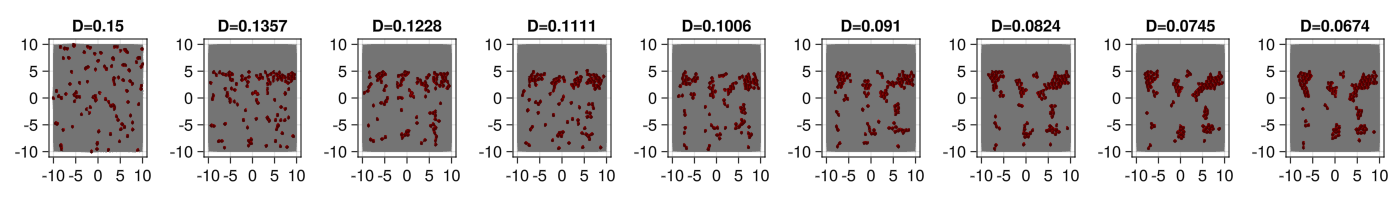

GLMakie.Screen(...)

In [14]:
d = getParameter(com,[:x,:y])

fig = Figure(resolution=(1400,200))

for (pos,i) in enumerate(1:999:8000)
    ax = Axis(fig[1,pos],title="D=$(round(com[i].D[1],digits=4))")
    mesh!(ax, [simBox[1,1] simBox[2,1];simBox[1,1] simBox[2,2];simBox[1,2] simBox[2,2];simBox[1,2] simBox[2,1]], [1 2 4; 2 3 4], color=:lightgrey)
    meshscatter!(ax,d[:x][i],d[:y][i],markersize=com[:rAtr][1]/2,color=(:blue,.0),transparency=true)
    meshscatter!(ax,d[:x][i],d[:y][i],markersize=com[:rRep][1]/2,
                color=[com[i].D[1] for i in 1:100],
                colorrange=(0.,0.15),
                colormap=:reds
                )
    xlims!(ax,(simBox[1,:].+[-1,1])...)
    ylims!(ax,(simBox[2,:].+[-1,1])...)
    # lines!(ax,[i[1] for i in d[:x]],[i[1] for i in d[:y]])
end

# save("agg.png",fig)

display(fig)
#save("C:/Users/s361359/CellBasedModelsF1/results/examples/particle_aggregation_repulsion_diffusion_example.png", fig)

#### Neighbors computational dependence

In [15]:
modelFull = ABM(2, baseModelInit=[model2], agentAlg = CBMIntegrators.EM(), neighborsAlg=CBMNeighbors.Full())
modelVerlet = ABM(2, baseModelInit=[model2], agentAlg = CBMIntegrators.EM(), neighborsAlg=CBMNeighbors.VerletDisplacement(skin=2,nMaxNeighbors=20))
modelCellLinked = ABM(2, baseModelInit=[model2], agentAlg = CBMIntegrators.EM(), neighborsAlg=CBMNeighbors.CellLinked(cellEdge=2))

function initialize(model,N,simBox)
        return Community(model,N=N,
                simBox = simBox,
                
                rRep=.8,
                fRep=1,
                rAtr=1.,
                fAtr=1.,
                D = .5,
                x=rand(N).*(simBox[1,2]-simBox[1,1]).+simBox[1,1],
                y=rand(N).*(simBox[2,2]-simBox[2,1]).+simBox[2,1],
                dt=.1
                );
end;

In [16]:
ρ=.1
S = 1

N = []
tFull = []
tVerlet = []
tCellLinked = []
for S in 1:.5:7
    simBox = S.*[-5. 5; -5 5]
    n = round(Int64,ρ*(simBox[1,2]-simBox[1,1])*(simBox[2,2]-simBox[2,1]))
    push!(N,n)

    com = initialize(modelFull,n,simBox); #Full (default) algorithm
    evolve!(com,steps=10,saveEach=10,saveCurrentState=true)
    t = @elapsed evolve!(com,steps=1000,saveEach=10,saveCurrentState=true)
    push!(tFull,t)

    com2 = initialize(modelVerlet,n,simBox); #Verlet list algorithm
    evolve!(com2,steps=10,saveEach=10,saveCurrentState=true)
    t = @elapsed evolve!(com2,steps=1000,saveEach=10,saveCurrentState=true)
    push!(tVerlet,t)

    com3 = initialize(modelCellLinked,n,simBox); #Cell linked algorithm
    evolve!(com3,steps=10,saveEach=10,saveCurrentState=true)
    t = @elapsed evolve!(com3,steps=1000,saveEach=10,saveCurrentState=true)
    push!(tCellLinked,t)
end

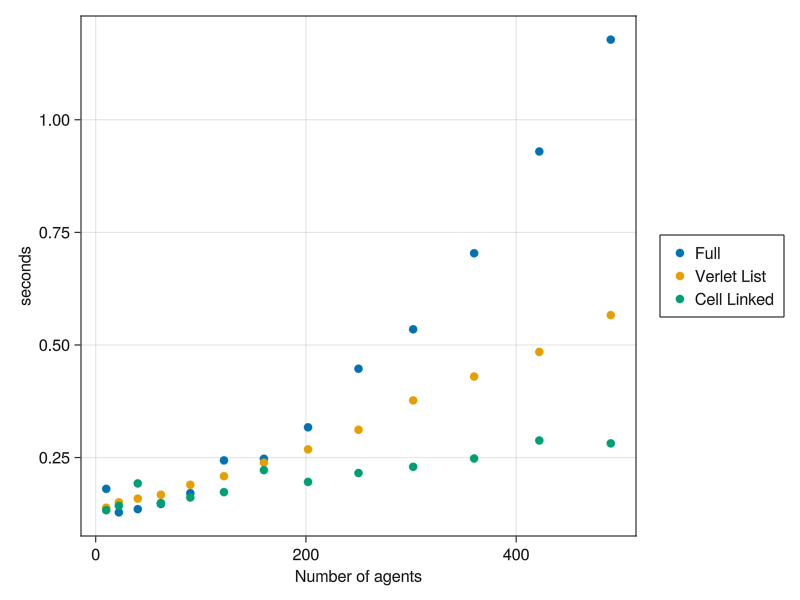

In [19]:
fig = Figure(resolution=(800,600))
ax = Axis(fig[1,1],xlabel="Number of agents",ylabel="seconds")

l1 = scatter!(ax,Float64.(N),Float64.(tFull))
l2 = scatter!(ax,Float64.(N),Float64.(tVerlet))
l3 = scatter!(ax,Float64.(N),Float64.(tCellLinked))
Legend(fig[1,2],[l1,l2,l3],["Full","Verlet List","Cell Linked"])

display(fig)
save("C:/Users/s361359/CellBasedModelsF1/results/examples/particle_aggregation_repulsion_statistics.png", fig)